In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation de : {device}")

Utilisation de : cuda


In [3]:
# ============ 1) Chargement et Prétraitement des Données ============
path_plm = "data/PLM_final.csv"
df_plm = pd.read_csv(path_plm, index_col=0)

path_expr = "data/expression_final.csv"
df_expr = pd.read_csv(path_expr, index_col=0)

# Alignement des données
common_genes = df_plm.index.intersection(df_expr.index)
df_plm = df_plm.loc[common_genes].sort_index()
df_expr = df_expr.loc[common_genes].sort_index()

# Conversion en tenseurs PyTorch
plm_matrix = torch.tensor(df_plm.values, dtype=torch.float32).to(device)
df_expr.replace({-1: 2}, inplace=True)  # Remplacer -1 par 2 pour éviter erreur avec CrossEntropy
labels = torch.tensor(df_expr.values, dtype=torch.long).to(device)
stress_conditions = torch.arange(df_expr.shape[1])

In [4]:
# ============ 2) Définition de la Classe Dataset ============
class GeneExpressionDataset(Dataset):
    def __init__(self, plm_matrix, stress_conditions, labels):
        self.plm_matrix = plm_matrix
        self.stress_conditions = stress_conditions
        self.labels = labels
        self.num_genes = plm_matrix.size(0)
        self.num_stress = stress_conditions.size(0)

    def __len__(self):
        return self.num_genes * self.num_stress

    def __getitem__(self, idx):
        gene_idx = idx // self.num_stress
        stress_idx = idx % self.num_stress
        plm_vector = self.plm_matrix[gene_idx]
        stress_id = self.stress_conditions[stress_idx]
        label = self.labels[gene_idx, stress_idx]
        return plm_vector, stress_id, label


In [5]:
# ============ 3) Définition du Modèle ============
class GeneExpressionModel(nn.Module):
    def __init__(self, num_plms, embedding_dim=16, hidden_dim=64, num_classes=3):
        super().__init__()
        self.plm_embedding = nn.Embedding(num_embeddings=num_plms, embedding_dim=embedding_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, plm_indices_batch):
        plm_embedded_batch = []
        for indices in plm_indices_batch:
            if indices.numel() == 0:
                aggregated = torch.zeros(self.plm_embedding.embedding_dim, device=indices.device)
            else:
                embedded = self.plm_embedding(indices)
                aggregated = embedded.mean(dim=0)
            plm_embedded_batch.append(aggregated)
        aggregated_plm = torch.stack(plm_embedded_batch, dim=0)
        return self.mlp(aggregated_plm)

In [6]:
# ============ 4) Préparation des Dataloaders ============
batch_size = 128
num_epochs = 50
learning_rate = 1e-3

dataset = GeneExpressionDataset(plm_matrix, stress_conditions, labels)

# Splitting train (70%), val (15%), test (15%)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_plms = plm_matrix.size(1)
model = GeneExpressionModel(num_plms)

if torch.cuda.device_count() > 1:
    print(f"🔹 Using {torch.cuda.device_count()} GPUs")
    model = torch.nn.DataParallel(model)

model = model.to(device)


# Calcul des poids de classe pour gérer le déséquilibre
num_samples = torch.bincount(labels.flatten(), minlength=3)
class_weights = 1.0 / num_samples.float()
class_weights /= class_weights.sum()

criterion = nn.CrossEntropyLoss(weight=class_weights.to(plm_matrix.device)).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [8]:
# ============ 5) Entraînement avec Validation ============
best_loss = float('inf')
patience = 3
counter = 0
train_losses, val_losses = [], []
start_epoch = 0
best_loss = float('inf')
checkpoint_path = "model.pth"

if os.path.exists(checkpoint_path):
    print("🔄 Chargement du modèle depuis le checkpoint existant...")
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    best_loss = checkpoint['best_loss']
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    start_epoch = checkpoint['epoch'] + 1  # Tiếp tục từ epoch tiếp theo
else:
    print("🚀 Aucun checkpoint trouvé, démarrage depuis zéro.")

# Entraînement avec Checkpoint
for epoch in range(start_epoch, num_epochs):
    model.train()
    total_train_loss = 0.0

    for plm_batch, stress_id_batch, label_batch in train_loader:
        plm_batch = plm_batch.to(device)
        stress_id_batch = stress_id_batch.to(device)
        label_batch = label_batch.to(device)

        optimizer.zero_grad()
        plm_indices_batch = [(plm_vec > 0).nonzero(as_tuple=True)[0] for plm_vec in plm_batch]
        outputs = model(plm_indices_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

# Validation 
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for plm_batch, stress_id_batch, label_batch in val_loader:
            plm_batch = plm_batch.to(device)
            stress_id_batch = stress_id_batch.to(device)
            label_batch = label_batch.to(device)

            plm_indices_batch = [(plm_vec > 0).nonzero(as_tuple=True)[0] for plm_vec in plm_batch]
            outputs = model(plm_indices_batch)
            loss = criterion(outputs, label_batch)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# Sauvegarde du Checkpoint
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_loss': best_loss,
            'train_losses': train_losses,
            'val_losses': val_losses
        }, checkpoint_path)
        print(f"✅ Modèle sauvegardé (epoch {epoch+1})")
        counter = 0  # Reset counter khi có cải thiện
    else:
        counter += 1
        if counter >= patience:
            print("🛑 Early stopping déclenché !")
            break

🚀 Aucun checkpoint trouvé, démarrage depuis zéro.
Epoch 1/50, Train Loss: 1.0923, Val Loss: 1.0868
✅ Modèle sauvegardé (epoch 1)
Epoch 2/50, Train Loss: 1.0857, Val Loss: 1.0802
✅ Modèle sauvegardé (epoch 2)
Epoch 3/50, Train Loss: 1.0814, Val Loss: 1.0760
✅ Modèle sauvegardé (epoch 3)
Epoch 4/50, Train Loss: 1.0783, Val Loss: 1.0725
✅ Modèle sauvegardé (epoch 4)
Epoch 5/50, Train Loss: 1.0757, Val Loss: 1.0708
✅ Modèle sauvegardé (epoch 5)
Epoch 6/50, Train Loss: 1.0740, Val Loss: 1.0684
✅ Modèle sauvegardé (epoch 6)
Epoch 7/50, Train Loss: 1.0725, Val Loss: 1.0672
✅ Modèle sauvegardé (epoch 7)
Epoch 8/50, Train Loss: 1.0713, Val Loss: 1.0659
✅ Modèle sauvegardé (epoch 8)
Epoch 9/50, Train Loss: 1.0700, Val Loss: 1.0651
✅ Modèle sauvegardé (epoch 9)
Epoch 10/50, Train Loss: 1.0695, Val Loss: 1.0646
✅ Modèle sauvegardé (epoch 10)
Epoch 11/50, Train Loss: 1.0688, Val Loss: 1.0634
✅ Modèle sauvegardé (epoch 11)
Epoch 12/50, Train Loss: 1.0680, Val Loss: 1.0623
✅ Modèle sauvegardé (epoch 

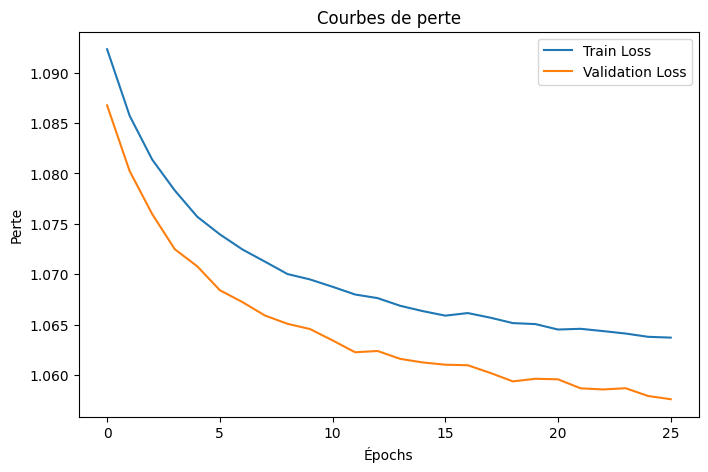

In [9]:
# ============ 6) Visualisation ============
checkpoint = torch.load(checkpoint_path)
train_losses = checkpoint['train_losses']
val_losses = checkpoint['val_losses']

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Épochs")
plt.ylabel("Perte")
plt.legend()
plt.title("Courbes de perte")
plt.show()

Test Accuracy: 0.6020


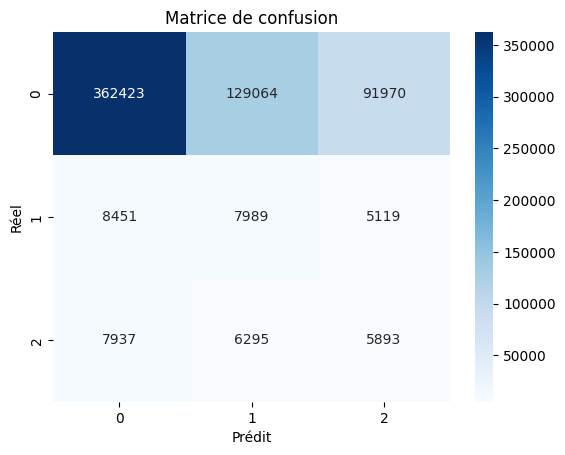

In [10]:
# ============ 7) Évaluation Finale ============
def evaluate_model(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for plm_batch, stress_id_batch, label_batch in dataloader:
            plm_indices_batch = [(plm_vec > 0).nonzero(as_tuple=True)[0].to(device) for plm_vec in plm_batch]
            outputs = model(plm_indices_batch)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(label_batch.cpu().numpy())  # Chỉ cần extend 1 lần

    acc = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {acc:.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.xlabel("Prédit")
    plt.ylabel("Réel")
    plt.title("Matrice de confusion")
    plt.show()

# Charger le meilleur modèle et évaluer
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
evaluate_model(model, test_loader)